In [1]:
from dataclasses import dataclass
from typing import *

import torch
from torch import nn


@dataclass
class CLIPTextConfig:
    vocab_size: int = 49408
    hidden_size: int = 512
    intermediate_size: int = 2048
    projection_dim: int = 512
    num_hidden_layers: int = 12
    num_attention_heads: int = 8
    max_position_embeddings: int = 77
    layer_norm_eps: float = 1e-5
    attention_dropout: float = 0.0
    # initializer_range: float = 0.02
    # initializer_factor: float = 1.0
    pad_token_id: int = 1
    bos_token_id: int = 49406  # 0
    eos_token_id: int = 49407  # 2


@dataclass
class CLIPVisionConfig:
    hidden_size: int = 768
    intermediate_size: int = 3072
    projection_dim: int = 512
    num_hidden_layers: int = 12
    num_attention_heads: int = 12
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 32
    layer_norm_eps: float = 1e-5
    attention_dropout: float = 0.0
    # initializer_range: float = 0.02
    # initializer_factor: float = 1.0


@dataclass
class CLIPConfig:
    text_config: CLIPTextConfig = CLIPTextConfig()
    vision_config: CLIPVisionConfig = CLIPVisionConfig()
    projection_dim: int = 512
    logit_scale_init_value: float = 2.6592
    # initializer_factor: float = 1.0


class QuickGELUActivation(nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * torch.sigmoid(1.702 * input)


class CLIPMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = QuickGELUActivation()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states


class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config: CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.class_embedding = nn.Parameter(torch.randn(self.embed_dim))

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            bias=False,
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches + 1
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        batch_size = pixel_values.shape[0]
        target_dtype = self.patch_embedding.weight.dtype
        patch_embeds = self.patch_embedding(
            pixel_values.to(dtype=target_dtype)
        )  # shape = [*, width, grid, grid]
        patch_embeds = patch_embeds.flatten(2).transpose(1, 2)

        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.cat([class_embeds, patch_embeds], dim=1)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings


class CLIPTextEmbeddings(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(
            config.max_position_embeddings, embed_dim
        )

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )

    def forward(
        self,
        input_ids: torch.LongTensor,
    ) -> torch.Tensor:
        seq_length = (
            input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]
        )

        position_ids = self.position_ids[:, :seq_length]
        inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings


class CLIPAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return (
            tensor.view(bsz, seq_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
            .contiguous()
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        causal_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Input shape: Batch x Time x Channel"""

        bsz, tgt_len, embed_dim = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scale
        key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
        value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if causal_attention_mask is not None:
            if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is"
                    f" {causal_attention_mask.size()}"
                )
            attn_weights = (
                attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
                + causal_attention_mask
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        attn_probs = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )
        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        return self.out_proj(attn_output)


class CLIPEncoderLayer(nn.Module):
    def __init__(self, config: Union[CLIPTextConfig, CLIPVisionConfig]):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        causal_attention_mask: torch.Tensor,
    ) -> torch.FloatTensor:
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attn(
            hidden_states=hidden_states,
            causal_attention_mask=causal_attention_mask,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states


class CLIPEncoder(nn.Module):
    def __init__(self, config: Union[CLIPTextConfig, CLIPVisionConfig]):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(
        self,
        inputs_embeds,
        causal_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            hidden_states = encoder_layer(
                hidden_states,
                causal_attention_mask,
            )
        return hidden_states


class CLIPTextModel(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPTextEmbeddings(config)
        self.encoder = CLIPEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

        self.eos_token_id = config.eos_token_id

    def _create_4d_causal_attention_mask(self, input_shape, dtype):
        bsz = input_shape[0]
        l = input_shape[-1]
        mask = torch.full((l, l), torch.finfo(dtype).min)
        mask_cond = torch.arange(mask.size(-1))
        mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
        mask = mask.to(dtype)
        mask = mask[None, None, :, :].expand(bsz, 1, l, l)
        return mask

    def forward(self, input_ids: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids)

        causal_attention_mask = self._create_4d_causal_attention_mask(
            input_shape, hidden_states.dtype
        )

        last_hidden_state = self.encoder(
            inputs_embeds=hidden_states,
            causal_attention_mask=causal_attention_mask,
        )

        last_hidden_state = self.final_layer_norm(last_hidden_state)

        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            (
                input_ids.to(dtype=torch.int, device=last_hidden_state.device)
                == self.eos_token_id
            )
            .int()
            .argmax(dim=-1),
        ]
        return last_hidden_state, pooled_output


class CLIPVisionModel(nn.Module):
    def __init__(self, config: CLIPVisionConfig):
        super().__init__()
        self.config = config

        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps
        )

    def forward(
        self,
        pixel_values: torch.FloatTensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        hidden_states = self.embeddings(pixel_values)
        hidden_states = self.pre_layrnorm(hidden_states)

        last_hidden_state = self.encoder(
            inputs_embeds=hidden_states,
        )

        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.post_layernorm(pooled_output)

        return last_hidden_state, pooled_output


class CLIPModel(nn.Module):
    def __init__(self, config: CLIPConfig):
        super().__init__()
        self.config = config

        self.projection_dim = config.projection_dim
        self.text_embed_dim = config.text_config.hidden_size
        self.vision_embed_dim = config.vision_config.hidden_size

        self.text_model = CLIPTextModel(config.text_config)
        self.vision_model = CLIPVisionModel(config.vision_config)

        self.visual_projection = nn.Linear(
            self.vision_embed_dim, self.projection_dim, bias=False
        )
        self.text_projection = nn.Linear(
            self.text_embed_dim, self.projection_dim, bias=False
        )
        self.logit_scale = nn.Parameter(
            torch.tensor(self.config.logit_scale_init_value)
        )

    def get_text_features(
        self,
        input_ids: torch.LongTensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        last_hidden_state, pooled_output = self.text_model(
            input_ids=input_ids,
        )

        return last_hidden_state, self.text_projection(pooled_output)

    def get_image_features(
        self,
        pixel_values: torch.FloatTensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        last_hidden_state, pooled_output = self.vision_model(
            pixel_values=pixel_values,
        )

        return last_hidden_state, self.visual_projection(pooled_output)

    def clip_loss(self, similarity: torch.Tensor) -> torch.Tensor:
        caption_loss = nn.functional.cross_entropy(
            similarity, torch.arange(len(similarity))
        )
        image_loss = nn.functional.cross_entropy(
            similarity.t(), torch.arange(len(similarity.t()))
        )
        return (caption_loss + image_loss) / 2.0

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
    ) -> Tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        image_last_hidden_states, image_embeds = self.get_image_features(
            pixel_values=pixel_values,
        )

        text_last_hidden_states, text_embeds = self.get_text_features(
            input_ids=input_ids,
        )

        image_embeds = image_embeds / image_embeds.norm(dim=1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_embeds @ text_embeds.t()
        logits_per_text = logits_per_image.t()

        return (
            logits_per_image,
            logits_per_text,
            text_embeds,
            image_embeds,
            image_last_hidden_states,
            text_last_hidden_states,
        )


## prepare model file
- download https://huggingface.co/openai/clip-vit-base-patch32/blob/main/pytorch_model.bin to /mnt/clip/clip-vit-base-patch32/pytorch_model.bin
- download https://huggingface.co/openai/clip-vit-base-patch32/blob/main/merges.txt to /mnt/clip/clip-vit-base-patch32/merges.txt
- download https://huggingface.co/openai/clip-vit-base-patch32/blob/main/vocab.json to /mnt/clip/clip-vit-base-patch32/vocab.json

In [2]:
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

checkpoint_path = '/mnt/clip/clip-vit-base-patch32/pytorch_model.bin'
state_dict = torch.load(checkpoint_path, map_location="cuda:0")

model_config = CLIPConfig()
clip_model = CLIPModel(model_config)
clip_model.load_state_dict(state_dict, strict=False)
print(clip_model)

CLIPModel(
  (text_model): CLIPTextModel(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, eleme

In [3]:
import json
import os
from functools import lru_cache
from typing import *

import regex as re

import ftfy


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a mapping to unicode strings. We specifically avoids mapping to whitespace/control
    characters the bpe code barfs on.

    The reversible bpe codes work on unicode strings. This means you need a large # of unicode characters in your vocab
    if you want to avoid UNKs. When you're at something like a 10B token dataset you end up needing around 5K for
    decent coverage. This is a significant percentage of your normal, say, 32K bpe vocab. To avoid that, we want lookup
    tables between utf-8 bytes and unicode strings.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1))
        + list(range(ord("¡"), ord("¬") + 1))
        + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """
    Return set of symbol pairs in a word.

    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


class CLIPTokenizer:
    def __init__(
        self,
        vocab_file,
        merges_file,
    ):
        with open(vocab_file, encoding="utf-8") as vocab_handle:
            self.encoder = json.load(vocab_handle)

        self.decoder = {v: k for k, v in self.encoder.items()}

        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}

        with open(merges_file, encoding="utf-8") as merges_handle:
            bpe_merges = (
                merges_handle.read().strip().split("\n")[1 : 49152 - 256 - 2 + 1]
            )  # =[1:]
        bpe_merges = [tuple(merge.split()) for merge in bpe_merges]
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))

        self.cache = {
            "<|startoftext|>": "<|startoftext|>",
            "<|endoftext|>": "<|endoftext|>",
        }

        self.pat = re.compile(
            r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""",
            re.IGNORECASE,
        )

        self.unk_token = "<|endoftext|>"
        self.bos_token = "<|startoftext|>"
        self.eos_token = "<|endoftext|>"
        self.pad_token = "<|endoftext|>"

        self.unk_token_id = 49407
        self.bos_token_id = 49406
        self.eos_token_id = 49407
        self.pad_token_id = 49407

    @property
    def vocab_size(self):
        return len(self.encoder)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]

        word = tuple(token[:-1]) + (token[-1] + "</w>",)
        pairs = get_pairs(word)

        if not pairs:
            return token + "</w>"

        while True:
            bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float("inf")))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                except ValueError:
                    new_word.extend(word[i:])
                    break
                else:
                    new_word.extend(word[i:j])
                    i = j

                if word[i] == first and i < len(word) - 1 and word[i + 1] == second:
                    new_word.append(first + second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = " ".join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        tokens = self._tokenize(text)
        return [self.encoder.get(t, self.unk_token_id) for t in tokens]

    def decode(self, ids):
        tokens = [self.decoder.get(index) for index in ids]
        return self.convert_tokens_to_string(tokens)

    def _tokenize(self, text):
        bpe_tokens = []

        text = ftfy.fix_text(text)
        text = re.sub(r"\s+", " ", text)
        text = text.strip().lower()

        for token in re.findall(self.pat, text):
            token = "".join(
                self.byte_encoder[b] for b in token.encode("utf-8")
            )  # Maps all our bytes to unicode strings, avoiding control tokens of the BPE (spaces in our case)
            bpe_tokens.extend(bpe_token for bpe_token in self.bpe(token).split(" "))
        return bpe_tokens

    def convert_tokens_to_string(self, tokens):
        text = "".join(tokens)
        byte_array = bytearray([self.byte_decoder[c] for c in text])
        text = byte_array.decode("utf-8", errors="replace").replace("</w>", " ").strip()
        return text


In [4]:
vocab_file = '/mnt/clip/clip-vit-base-patch32/vocab.json'
merges_file = '/mnt/clip/clip-vit-base-patch32/merges.txt'
tokenizer = CLIPTokenizer(vocab_file, merges_file)

input_ids = tokenizer.encode('a photo of a cat')

print(input_ids)

input_ids = torch.LongTensor([input_ids]).cuda()

_, text_embeddings = clip_model.get_text_features(input_ids)
text_embeddings = text_embeddings / text_embeddings.norm(dim=1,keepdim=True)

text_embeddings = text_embeddings[0]
print(text_embeddings.shape)

[320, 1125, 539, 320, 2368]
torch.Size([512])


In [5]:
from PIL import Image
import numpy as np

image_mean = [0.48145466,0.4578275,0.40821073]
image_std = [0.26862954,0.26130258,0.27577711]

image_paths = ['./data/n02687172_aircraft_carrier.jpeg', './data/n02974003_car_wheel.jpeg']
images = []
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    resized_image = image.resize((224,224), resample=Image.Resampling.BICUBIC)
    image_arr = np.array(resized_image) # (height,width,3)
    image_arr = image_arr * 1/225.0
    normalized_image_arr = (image_arr - image_mean) / image_std
    normalized_image_arr = normalized_image_arr.transpose(2, 0, 1) # (c, h, w)
    images.append(normalized_image_arr)

images = np.array(images)
    
    
# inference
pixel_values = torch.Tensor(images).cuda()
_, image_embeddings = clip_model.get_image_features(pixel_values)    
image_embeddings = image_embeddings / image_embeddings.norm(dim=1,keepdim=True)
print(image_embeddings.shape)

# mean
image_embeddings_mean = torch.mean(image_embeddings,dim=0)

print(image_embeddings_mean.shape)


torch.Size([2, 512])
torch.Size([512])


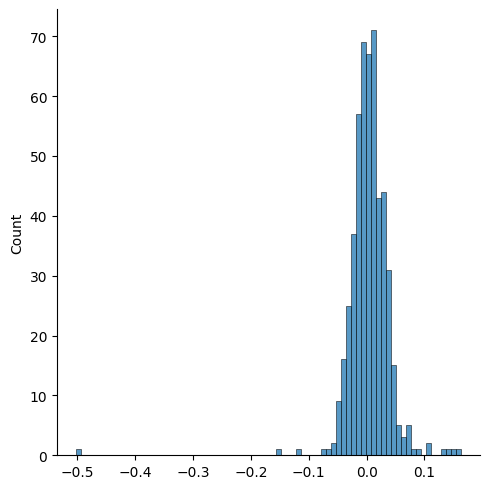

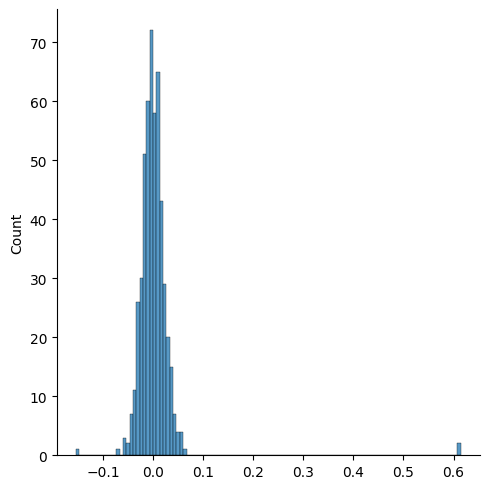

In [6]:
import seaborn as sns
import numpy as np

sns.displot(np.array(image_embeddings_mean.tolist()))
sns.displot(np.array(text_embeddings.tolist()))